In [1]:
from google.cloud import bigquery
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Load your data
client = bigquery.Client()


In [2]:

query = """
    SELECT shipping_latitude, shipping_longitude from `no-maintenance`.shopify.orders
    WHERE shipping_latitude IS NOT NULL and shipping_longitude IS NOT NULL and json_extract_scalar(shipping_address, '$.country_code') = 'US'
    """

In [3]:
import pandas_gbq
df = pandas_gbq.read_gbq(query, project_id=client.project)
X = df[['shipping_latitude', 'shipping_longitude']].values

Downloading: 100%|██████████|


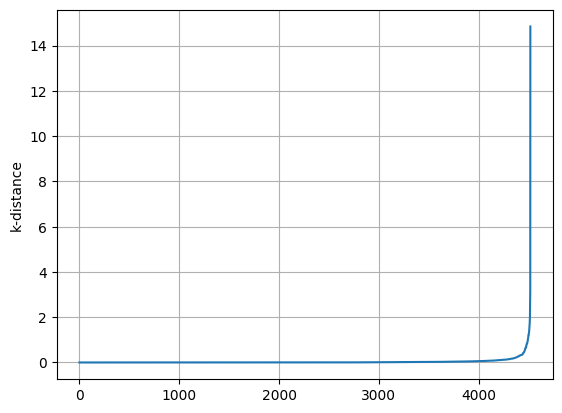

In [4]:
from sklearn.neighbors import NearestNeighbors

# Choose k (for example, the 4th nearest neighbor)
k = 4

# Fit the NearestNeighbors model
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

# Find the distances and indices of the k nearest neighbors
distances, indices = nn.kneighbors(X)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the k-distance graph
plt.plot(distances)
plt.ylabel('k-distance')
plt.grid(True)
plt.show()


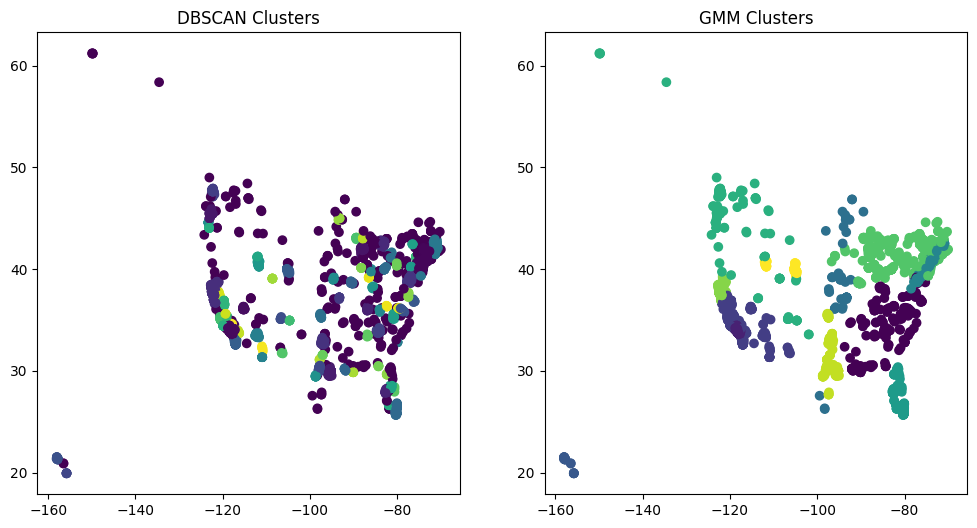

gmm_cluster
5     1112
1     1063
8      505
9      377
2      348
0      313
7      237
10     235
6      157
11      85
4       62
3       25
Name: count, dtype: int64


In [5]:
# Prepare the data for clustering

# Step 2: Initial Clustering with DBSCAN
# eps and min_samples are hyperparameters that you may need to adjust depending on your data
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Add the DBSCAN cluster labels to the DataFrame
df['dbscan_cluster'] = dbscan_labels

# Step 3: Refining Clusters with GMM
# n_components is a hyperparameter that you may need to adjust depending on your data
gmm = GaussianMixture(n_components=12)
gmm_labels = gmm.fit_predict(X)

# Add the GMM cluster labels to the DataFrame
df['gmm_cluster'] = gmm_labels

# Step 4: Visualization
plt.figure(figsize=(12, 6))

# Plot DBSCAN clusters
plt.subplot(121)
plt.scatter(df['shipping_longitude'], df['shipping_latitude'], c=df['dbscan_cluster'])
plt.title('DBSCAN Clusters')

# Plot GMM clusters
plt.subplot(122)
plt.scatter(df['shipping_longitude'], df['shipping_latitude'], c=df['gmm_cluster'])
plt.title('GMM Clusters')

plt.show()

# Step 5: Analysis and Interpretation
# For example, you might want to look at the number of orders in each GMM cluster
cluster_counts = df['gmm_cluster'].value_counts()
print(cluster_counts)

In [6]:
import folium

# Step 4: Visualization with folium
# Create a map centered around the mean latitude and longitude values
map = folium.Map(location=[df['shipping_latitude'].mean(), df['shipping_longitude'].mean()], zoom_start=2)

# Add a marker for each order, colored by GMM cluster
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'black', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
for lat, lon, cluster in zip(df['shipping_latitude'], df['shipping_longitude'], df['gmm_cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map)

# Display the map

# Step 5: Analysis and Interpretation
# For example, you might want to look at the number of orders in each GMM cluster
cluster_counts = df['gmm_cluster'].value_counts()
print(cluster_counts)

gmm_cluster
5     1112
1     1063
8      505
9      377
2      348
0      313
7      237
10     235
6      157
11      85
4       62
3       25
Name: count, dtype: int64


In [7]:
map